In [1]:
from ucimlrepo import fetch_ucirepo 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_circles
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import rand_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.tree import plot_tree


# fetch dataset 
chronic_kidney_disease = fetch_ucirepo(id=336) 
# data (as pandas dataframes) 
X = chronic_kidney_disease.data.features 
y = chronic_kidney_disease.data.targets 



for i in range(len(y)):
    if y.loc[i, "class"] == "ckd\t":
        y.loc[i, "class"] = "ckd"

X["dm"].isna().sum()

distinct6 = set(X["dm"])


for i in range(len(y)):
    if X.loc[i, "dm"] == "\tno":
        X.loc[i, "dm"] = "no"

disty = set(y["class"])
print(disty)

{'ckd', 'notckd'}


/var/folders/12/3k_y6s813s1d8qf4r87n32080000gn/T/ipykernel_59765/1943349709.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[i, "class"] = "ckd"


# 2. 
We decide to use Decision Tree and Support Vector Machine(SVM) to classify the data. For Decision Tree, it is unnecessary to transform the variables, because they are not sensitive to feature scaling. Doing so will not change the result. However, normalize the data could be useful for SVM, we will standardlize numerical columns after we have an overview of the dataset and use them when we fit SVM model for the data in later codes. 


In [3]:
print(X.dtypes)
print(y.dtypes)

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
dtype: object
class    object
dtype: object


In [4]:
X.isna().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64

In [5]:
cat = ['rbc', 'pc', 'pcc','ba','htn','dm','cad','appet','pe','ane','al','su']
#al and su are categorical variables, though their type is float64.

for col in cat:
    X[col] = pd.Categorical(X[col]).codes


In [6]:
#After the previous processing, categorical variables are now switched into numbers for model processing. However, we would like to still keep the NA and process them in later coding.

for col in cat:
    X[col] = X[col].replace(-1, np.nan)


X.isna().sum()


age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64

# 3. Dataset Overview

In [7]:
print(y)

      class
0       ckd
1       ckd
2       ckd
3       ckd
4       ckd
..      ...
395  notckd
396  notckd
397  notckd
398  notckd
399  notckd

[400 rows x 1 columns]


We manually check the dictionary from the data source webstite. For variable "al" and "su", although they have a type of "float", they are actually discreate numbers, so we treat them as categorical datas.

In [8]:
categorcal_cols = ['rbc', 'pc', 'pcc','ba','htn','dm','cad','appet','pe','ane','al','su']
numerical_cols = ["age","bp","sg","bgr","bu","sc","sod","pot","hemo","pcv","wbcc","rbcc"]

In [9]:
print(X.shape)
print(y.shape)



(400, 24)
(400, 1)


In [10]:
X[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,391.0,51.483376,17.169714,2.000,42.00,55.00,64.50,90.000
bp,388.0,76.469072,13.683637,50.000,70.00,80.00,80.00,180.000
sg,353.0,1.017408,0.005717,1.005,1.01,1.02,1.02,1.025
bgr,356.0,148.036517,79.281714,22.000,99.00,121.00,163.00,490.000
bu,381.0,57.425722,50.503006,1.500,27.00,42.00,66.00,391.000
sc,383.0,3.072454,5.741126,0.400,0.90,1.30,2.80,76.000
sod,313.0,137.528754,10.408752,4.500,135.00,138.00,142.00,163.000
pot,312.0,4.627244,3.193904,2.500,3.80,4.40,4.90,47.000
hemo,348.0,12.526437,2.912587,3.100,10.30,12.65,15.00,17.800
pcv,329.0,38.884498,8.990105,9.000,32.00,40.00,45.00,54.000


In [11]:
X[categorcal_cols]

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,al,su
0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,3.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,4.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
numeric_X = X.select_dtypes(include=['float'])

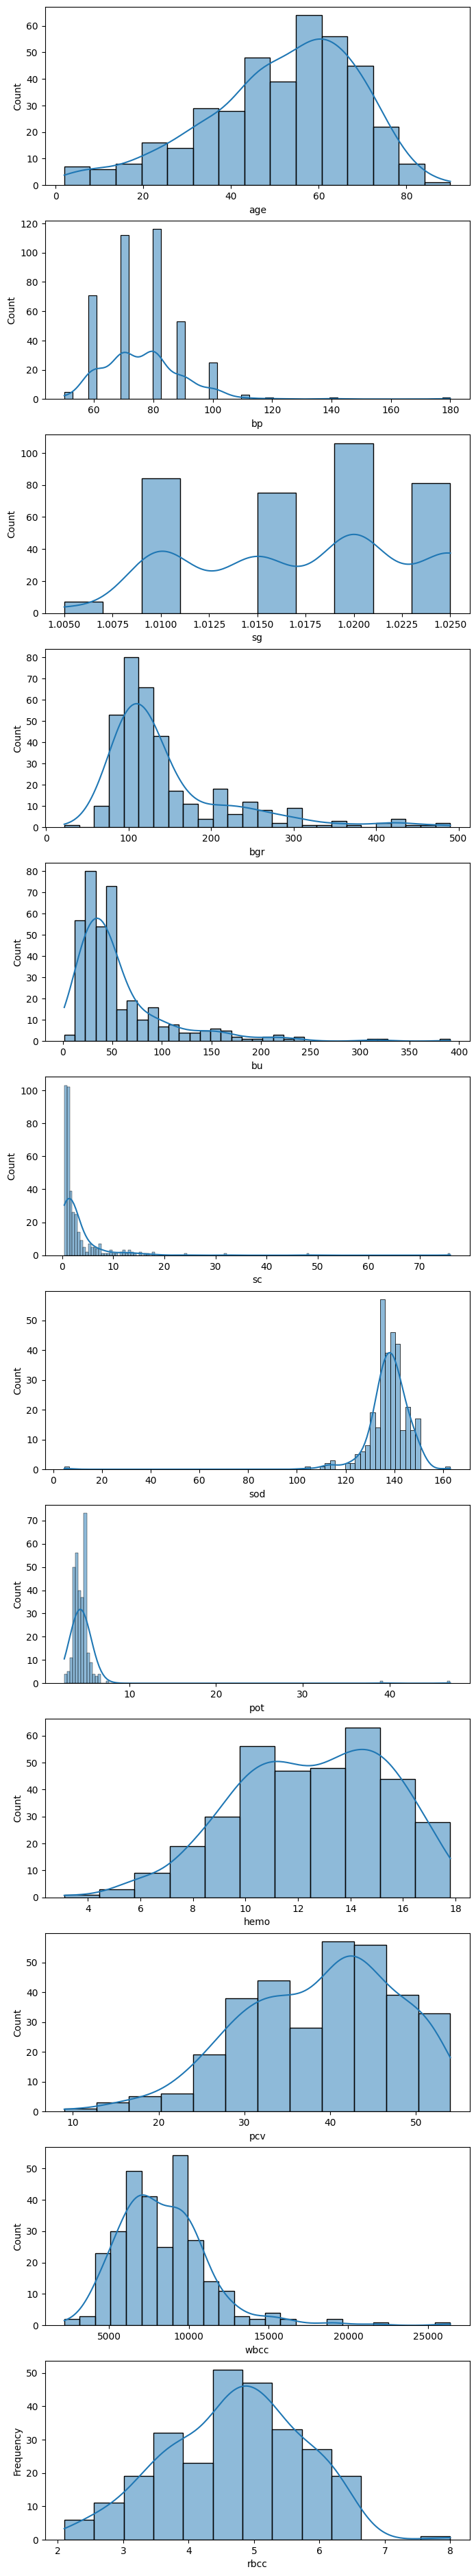

In [13]:
def plot_dist(data, features):
    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 4 * len(features)))
    if len(features) == 1:
        axes = [axes]
    for ax, feature in zip(axes, features):
        sns.histplot(data[feature], kde=True, ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
plt.show()
plot_dist(X,numerical_cols)

# 4

The heatmap below shows the corrlations of the combinations of the variables.

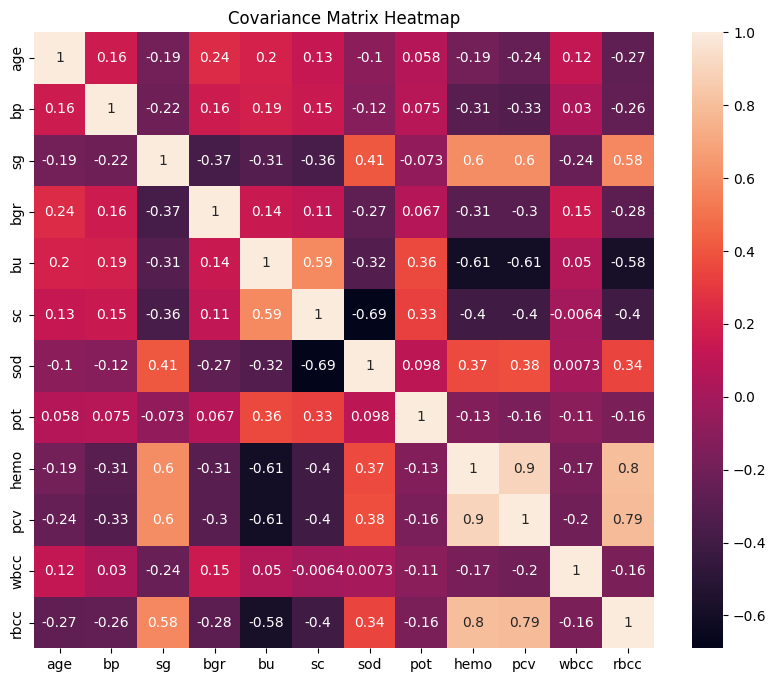

In [16]:
# Plot heatmap of covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X[numerical_cols].corr(),annot=True)
plt.title('Covariance Matrix Heatmap')
plt.show()

Relation between "sod" and "sc" has the most negative corrleation;

Relation between "hemo" and "rbcc" has the most positive corrleation.;

Relation between "wbcc" and "bp" has the smallest corrleation, which means they are close to a independent relation. 

# 5
For quantitative variables, we replace the missing values by the mean of each column. For categorical variables, we replace the missing values by the most frequently appeared value in each column. However, we will not process the missing values now since Decision Tree can accept missing values. We will impute missing values before we use SVM.

# 6 Outlier Analysis

From the histogrms below we obtain that some outliers do exist. However, we decide not to remove them because a certain value in a certain column may be influenced by other variables, we cannot find a clear method or rule to remove the outliers though we got a heatmap. Also, some of the medical data may be conclusive in determing the disease, so we think keep these outlier here is not necessary.

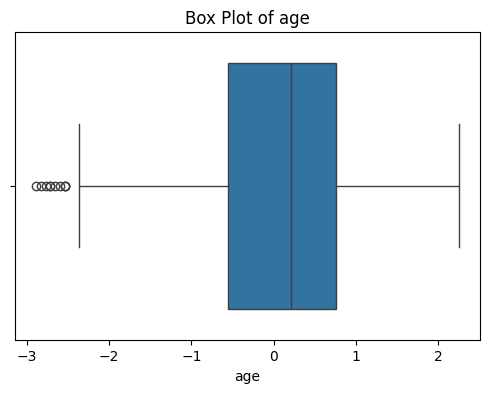

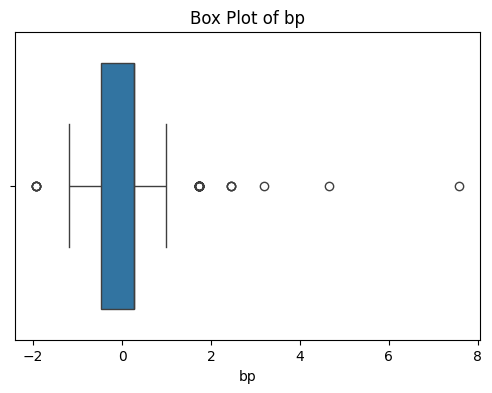

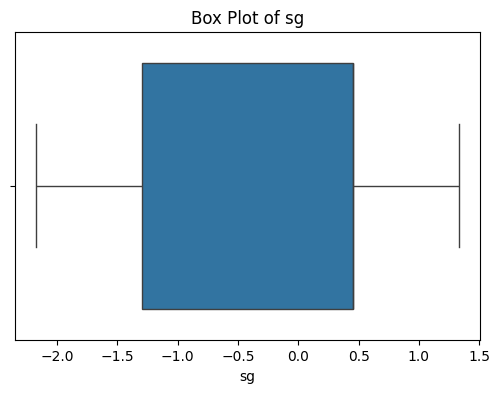

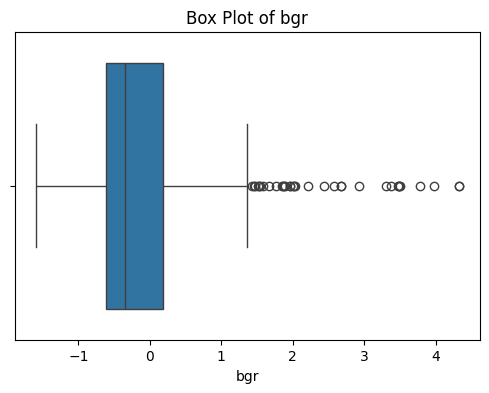

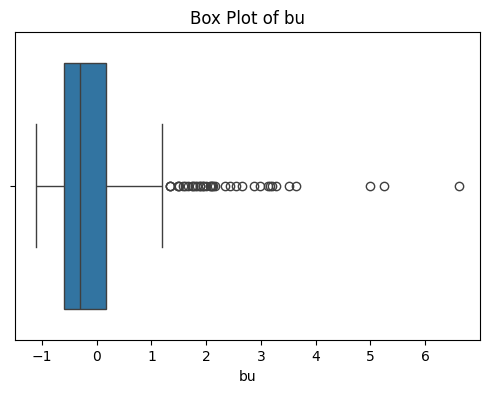

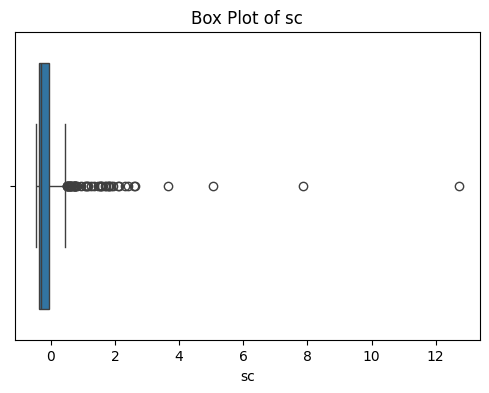

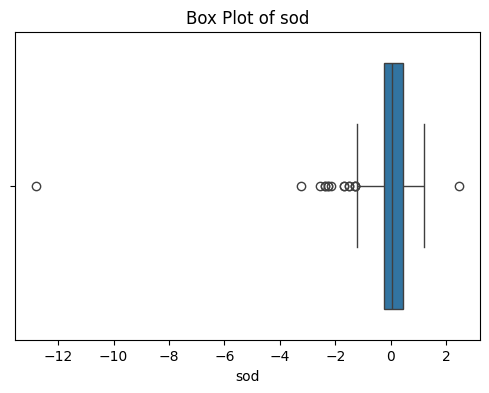

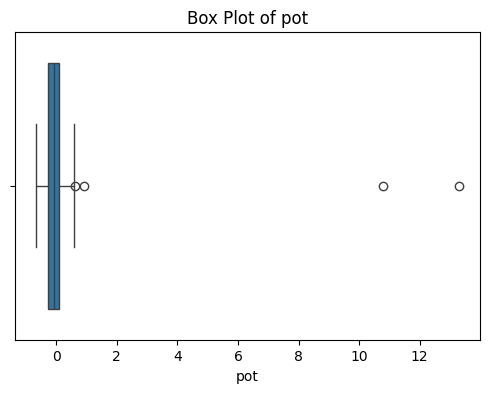

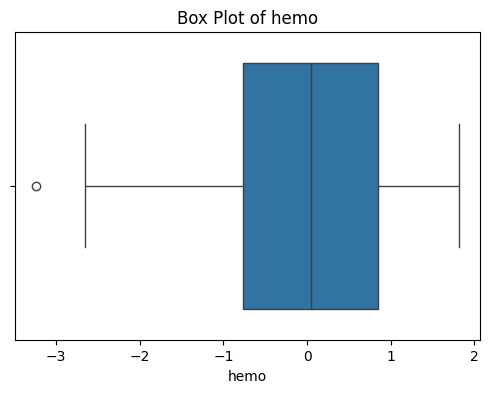

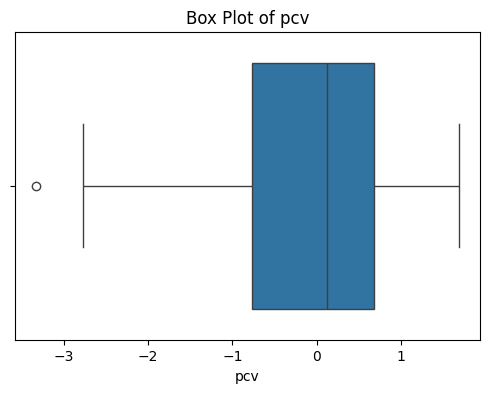

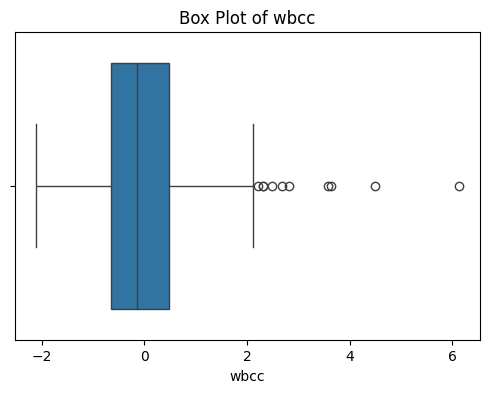

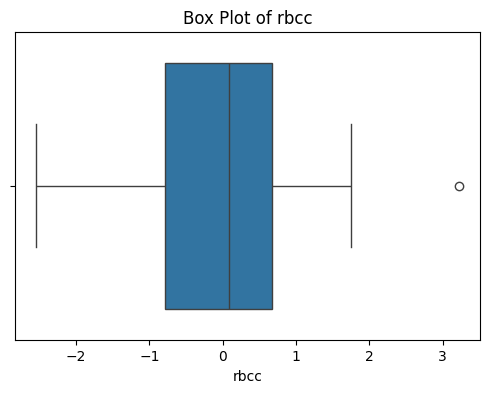

In [17]:

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=X[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()

# 11. 
Here we use two methods to improve the performance on decision tree. First method we prune the tree. Second Method, we fit our data with criterion='entropy', we did some research, and we agree on using entropy instead of "gini" is more suitable for this dataset, and its performance also proves that.

In [25]:
path = cs_dt.cost_complexity_pruning_path(
    X_train, 
    y_train
)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [26]:
clfs = [] # save fitted trees with different alphas
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=0, 
        ccp_alpha=ccp_alpha
        )
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [27]:
depth = [clf.tree_.max_depth for clf in clfs]
depth

[5, 5, 3, 2, 2, 1, 0]

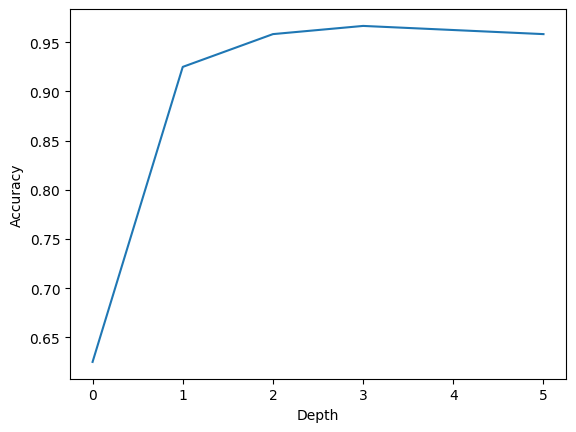

In [28]:
test_score = [clf.score(X_test, y_test) for clf in clfs]
plt.plot(depth, test_score)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()